# 09. PyTorch Model Deployment Exercises

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) > 1, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


torch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 26.88 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7986c6bada80>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

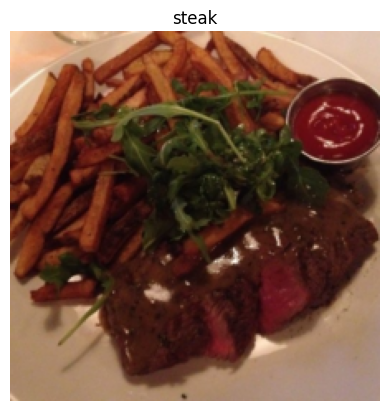

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [ ]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list


[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi/test


## EffnetB2

In [ ]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 104MB/s]


In [ ]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


In [ ]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/sushi/46797.jpg,sushi,0.9143,sushi,0.1565,True
1,data/pizza_steak_sushi/test/sushi/780283.jpg,sushi,0.8358,sushi,0.1221,True
2,data/pizza_steak_sushi/test/sushi/128616.jpg,sushi,0.9492,sushi,0.1151,True
3,data/pizza_steak_sushi/test/sushi/592799.jpg,sushi,0.9095,sushi,0.1136,True
4,data/pizza_steak_sushi/test/sushi/2903621.jpg,sushi,0.7403,sushi,0.1177,True


In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction with the CPU: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction with the CPU: 0.1389 seconds


In [ ]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cuda") # make predictions on GPU this time

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/sushi/46797.jpg,sushi,0.9143,sushi,0.0522,True
1,data/pizza_steak_sushi/test/sushi/780283.jpg,sushi,0.8358,sushi,0.0254,True
2,data/pizza_steak_sushi/test/sushi/128616.jpg,sushi,0.9492,sushi,0.0354,True
3,data/pizza_steak_sushi/test/sushi/592799.jpg,sushi,0.9095,sushi,0.0340,True
4,data/pizza_steak_sushi/test/sushi/2903621.jpg,sushi,0.7403,sushi,0.0331,True


In [ ]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction with the GPU: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction with the GPU: 0.0286 seconds


Using the CPU: 0.1389 seconds **VS** Using the GPU: 0.029 seconds

**So the GPU is ~ 5x faster than the CPU.**

## ViT

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [ ]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 117MB/s]


In [ ]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/sushi/46797.jpg,sushi,0.9923,sushi,1.4175,True
1,data/pizza_steak_sushi/test/sushi/780283.jpg,sushi,0.8256,sushi,0.7236,True
2,data/pizza_steak_sushi/test/sushi/128616.jpg,sushi,0.9876,sushi,0.6817,True
3,data/pizza_steak_sushi/test/sushi/592799.jpg,sushi,0.9891,sushi,0.6707,True
4,data/pizza_steak_sushi/test/sushi/2903621.jpg,sushi,0.9072,sushi,0.6868,True


In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction with the CPU: {vit_average_time_per_pred} seconds")

ViT average time per prediction with the CPU: 0.7453 seconds


In [ ]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cuda") # make predictions on GPU this time

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi/test/sushi/46797.jpg,sushi,0.9923,sushi,0.2533,True
1,data/pizza_steak_sushi/test/sushi/780283.jpg,sushi,0.8256,sushi,0.0363,True
2,data/pizza_steak_sushi/test/sushi/128616.jpg,sushi,0.9876,sushi,0.0346,True
3,data/pizza_steak_sushi/test/sushi/592799.jpg,sushi,0.9891,sushi,0.0353,True
4,data/pizza_steak_sushi/test/sushi/2903621.jpg,sushi,0.9072,sushi,0.0356,True


In [ ]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction with the GPU: {vit_average_time_per_pred} seconds")

ViT average time per prediction with the GPU: 0.0285 seconds


Using the CPU: 0.7453 seconds **VS** Using the GPU: 0.0285 seconds

**So the GPU is ~ 26x faster than the CPU, for the Transformer!**

## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

In [ ]:
# Create ViT model and transforms
vit_food_101, vit_food_101__transforms = create_vit_model(num_classes=101,
                                       seed=42)

In [ ]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_food_101__transforms
])

In [ ]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{vit_food_101__transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

Testing transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=vit_food_101__transforms, # perform normal ViT transforms on test data
                             download=True)

100%|██████████| 4996278331/4996278331 [03:16<00:00, 25373690.45it/s]


Extracting data/food-101.tar.gz to data


In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [ ]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [ ]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit_food_101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
vit_food101_results = engine.train(model=vit_food_101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8532 | train_acc: 0.4279 | test_loss: 2.0665 | test_acc: 0.6257
Epoch: 2 | train_loss: 2.2209 | train_acc: 0.5931 | test_loss: 1.9249 | test_acc: 0.6657
Epoch: 3 | train_loss: 2.0587 | train_acc: 0.6439 | test_loss: 1.8675 | test_acc: 0.6981
Epoch: 4 | train_loss: 1.9557 | train_acc: 0.6810 | test_loss: 1.8514 | test_acc: 0.6989
Epoch: 5 | train_loss: 1.8883 | train_acc: 0.7009 | test_loss: 1.8297 | test_acc: 0.7078


Again, we beat the original Food101 paper's results of 56.4% accuracy with only 20% of the training data (though we only evaluated on 20% of the testing data too, to fully replicate the results, we could evaluate on 100% of the testing data).

**Specifically, we got 70.78 % testing accuracy.**

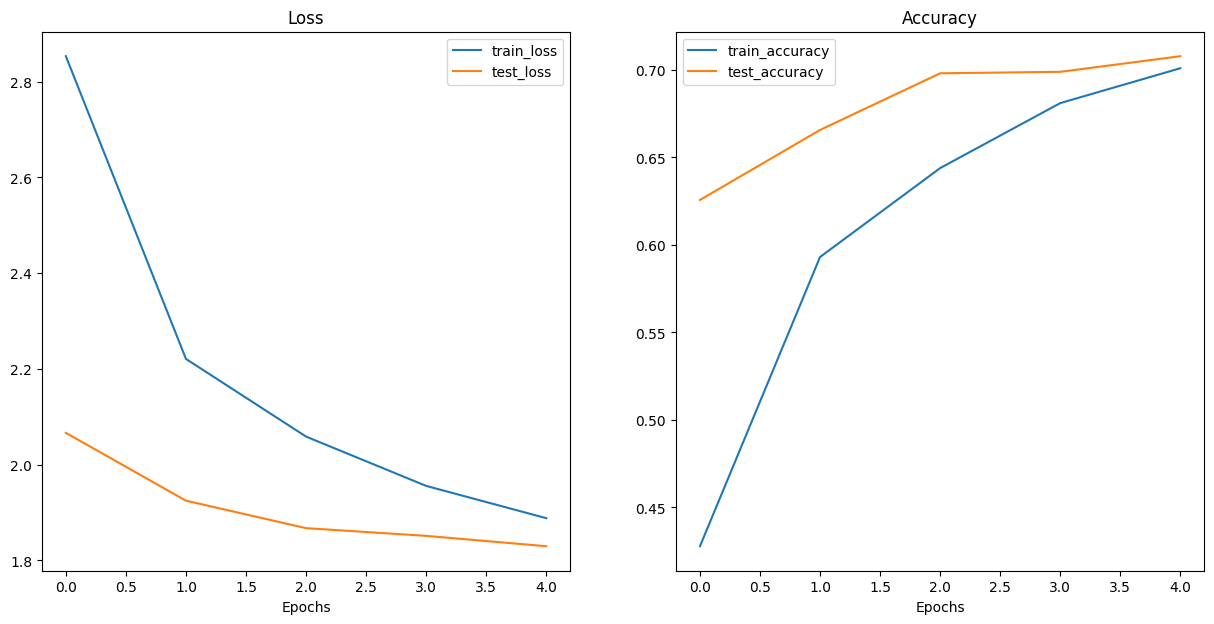

In [ ]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(vit_food101_results)

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

## From solutions:

In [ ]:
# Loop through test DataLoader (with batch size 1)
# Make prediction with model
# Store prediction and prediction probability to dictionary
# Append dictionary to list
# Inspect list

# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_batch_size_1 = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                  batch_size=1,
                                                  shuffle=False,
                                                  num_workers=NUM_WORKERS)

# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food_101.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_pred_list = []
for X, y in tqdm(test_dataloader_food101_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_pred_list.append(pred_dict)

  0%|          | 0/5050 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
# Create DataFrame with various columns
pred_df_20_percent = pd.DataFrame(vit_food101_pred_list)

# Create a column for if the prediction is correct
pred_df_20_percent["is_correct"] = pred_df_20_percent["pred_label"] == pred_df_20_percent["label"]

# Create class name columns (e.g. pred_label=72 -> pred_class="pancakes")
pred_df_20_percent["pred_class"] = pred_df_20_percent["pred_label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent["label_class"] = pred_df_20_percent["label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent.head()

,pred_prob,pred_label,label,is_correct,pred_class,label_class
0,0.023728224,79,72,False,prime_rib,pancakes
1,0.027895892,10,57,False,bruschetta,hummus
2,0.022860508,10,80,False,bruschetta,pulled_pork_sandwich
3,0.018407227,5,51,False,beet_salad,guacamole
4,0.026512157,60,1,False,lobster_bisque,baby_back_ribs


In [ ]:
# Get top 10 samples that are "most wrong", e.g. highest pred_prob but wrong prediction - why??
pred_df_20_percent[pred_df_20_percent["is_correct"] == False].sort_values("pred_prob", ascending=False)[:10]

,pred_prob,pred_label,label,is_correct,pred_class,label_class
629,0.046851404,5,28,False,beet_salad,croque_madame
4183,0.046551578,58,21,False,ice_cream,chocolate_cake
245,0.045250364,62,34,False,macaroni_and_cheese,eggs_benedict
3054,0.044394676,62,8,False,macaroni_and_cheese,bread_pudding
4021,0.043887965,55,63,False,hot_dog,macarons
2978,0.043509874,23,97,False,churros,takoyaki
4654,0.04228702,95,30,False,sushi,deviled_eggs
4727,0.041834585,28,23,False,croque_madame,churros
466,0.041804757,86,21,False,sashimi,chocolate_cake
3470,0.041763905,87,83,False,scallops,red_velvet_cake


Comparing the "pred_class" to the "label_class" the model is **often wrong on samples that are visually similar.**
For example, gyoza and dumplings look quite the same.
The same as paella and fried rice.
And onion rings and fried calamari.
The model is getting confused on similar looking classes and thus predictions are in the right "space" but not necessarily correct compared to the ground truth.

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

## WRONG Interpretation of question - I attempted to train and test anew the ViT on the FULL Food101 dataset.

In [ ]:
train_data_food101_full = train_data
test_data_food101_full = test_data

len(train_data_food101_full), len(test_data_food101_full)

(75750, 25250)

In [ ]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 training DataLoader
train_dataloader_food101_full = torch.utils.data.DataLoader(train_data_food101_full,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 testing DataLoader
test_dataloader_food101_full = torch.utils.data.DataLoader(test_data_food101_full,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit_food_101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with the full data, need 56.4%+ acc on test dataset
set_seeds()
vit_food101_full_results = engine.train(model=vit_food_101,
                                        train_dataloader=train_dataloader_food101_full,
                                        test_dataloader=test_dataloader_food101_full,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

ModuleNotFoundError: No module named 'going_modular'

Again, we clearly beat the original Food101 paper's results of 56.4% accuracy evaluating on the full data.

**Specifically, we got [Even for the first epoch, the accuracy is around 76%, but it takes around 2 hours to train with the free GPU and I ran out of runtime] % testing accuracy.**

- Come back to this later.

## Correct interpretation from SOLUTIONS == use the ViT trained on 20% of the data, and test on the full data - AGAIN, USE EVAL MODE.

In [ ]:
# Check length of Food101 test data
len(test_data)

25250

In [ ]:
# Turn Food101 test data into DataLoader
# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_all_data_batch_size_1 = torch.utils.data.DataLoader(test_data,
                                                           batch_size=1,
                                                           shuffle=False,
                                                           num_workers=NUM_WORKERS)

len(test_dataloader_food101_all_data_batch_size_1)

25250

In [ ]:
# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_all_test_data_pred_list = []
for X, y in tqdm(test_dataloader_food101_all_data_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_all_test_data_pred_list.append(pred_dict)

  0%|          | 0/25250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Evalaute model on entire test set
food101_all_test_data_df = pd.DataFrame(vit_food101_all_test_data_pred_list)
food101_all_test_data_df["is_correct"] = food101_all_test_data_df["pred_label"] == food101_all_test_data_df["label"]
food101_all_test_data_df.is_correct.value_counts()

In [ ]:
# Calculate accuracy across Food101 all test
print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[1] / len(food101_all_test_data_df)}")

## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

Currently (June 2024), the best performing model on the Food101 dataset for Image Classification without extra training data is the **Bamboo (ViTB/16) model (so a transformer)**, with a test accuracy of **92.9%**. See the relevant paper, published in 2022: https://paperswithcode.com/paper/bamboo-building-mega-scale-vision-dataset


- Note: For "fine-grained image classification" the best performing model is CAP, with 98.6% accuracy, which is a CNN utilizing a novel type of "context-aware" pooling (https://paperswithcode.com/paper/context-aware-attentional-pooling-cap-for).

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.

* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

See the deployed FoodVision Mini model here: https://huggingface.co/spaces/mrdbourke/foodvision_mini

Problems:
1. **Someone uploads a photo that isn't food...**
  * Potential solution: train two models, one that classifies images into "food" or "not food" and if an image is found to be "not food" display a message, if it is found to be "food", classify it into a certain class.
2. **Someone uploads a photo of food but our model doesn't have the capacity to classify that certain class...**
  * Potential solutions:
    1. Get more data for unknown classes (upgrade the model).
    2. Ask someone if the prediction is right/wrong, if it's wrong, track it to a database and update later (active learning - https://en.wikipedia.org/wiki/Active_learning_(machine_learning)).
3. **The image quality is poor (food in top left of image rather than center)**
  * Potential solution: add guidelines to the camera app to hint at taking a photo with the subject in the middle
4. **Multiple foods in one shot**
  * Potential solution:
    1. Return multiple classification results (e.g. the top 5 classification predication probabilities)
    2. Object detection (detect each different food in an image and individually classify them)

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

## Create and train model

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [ ]:
# Create ViT model and transforms
# The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
# https://www.cs.toronto.edu/~kriz/cifar.html

vit_CIFAR, vit_CIFAR__transforms = create_vit_model(num_classes=10,
                                       seed=42)

In [ ]:
CIFAR_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_CIFAR__transforms
])

In [ ]:
print(f"Training transforms:\n{CIFAR_train_transforms}\n")
print(f"Testing transforms:\n{vit_CIFAR__transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

Testing transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Small dataset, no need (and can't) to split

train_data_CIFAR = datasets.CIFAR10(root=data_dir, # path to download data to
                              transform=CIFAR_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

test_data_CIFAR = datasets.CIFAR10(root=data_dir,
                             transform=vit_CIFAR__transforms, # perform normal ViT transforms on test data
                             download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Get Food101 class names
CIFAR_class_names = train_data.classes

# View the first 10
CIFAR_class_names[:10]

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split?
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length

    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [ ]:
# Create training 20% split of CIFAR
train_data_CIFAR_20_percent, _ = split_dataset(dataset=train_data_CIFAR,
                                                 split_size=0.2)

# Create testing 20% split of CIFAR
test_data_CIFAR_20_percent, _ = split_dataset(dataset=test_data_CIFAR,
                                                split_size=0.2)

len(train_data_CIFAR_20_percent), len(test_data_CIFAR_20_percent)

[INFO] Splitting dataset of length 50000 into splits of size: 10000 (20%), 40000 (80%)
[INFO] Splitting dataset of length 50000 into splits of size: 10000 (20%), 40000 (80%)


(10000, 10000)

In [ ]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_CIFAR= torch.utils.data.DataLoader(train_data_CIFAR_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_CIFAR = torch.utils.data.DataLoader(test_data_CIFAR_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

In [ ]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit_CIFAR.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0) # W/O LABEL SMOOTHING

set_seeds()
vit_CIFAR_results = engine.train(model=vit_CIFAR,
                                        train_dataloader=train_dataloader_CIFAR,
                                        test_dataloader=test_dataloader_CIFAR,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7438 | train_acc: 0.7660 | test_loss: 0.2102 | test_acc: 0.9400
Epoch: 2 | train_loss: 0.5394 | train_acc: 0.8156 | test_loss: 0.1682 | test_acc: 0.9484
Epoch: 3 | train_loss: 0.5162 | train_acc: 0.8211 | test_loss: 0.1532 | test_acc: 0.9511
Epoch: 4 | train_loss: 0.4946 | train_acc: 0.8302 | test_loss: 0.1403 | test_acc: 0.9564
Epoch: 5 | train_loss: 0.4883 | train_acc: 0.8340 | test_loss: 0.1316 | test_acc: 0.9603


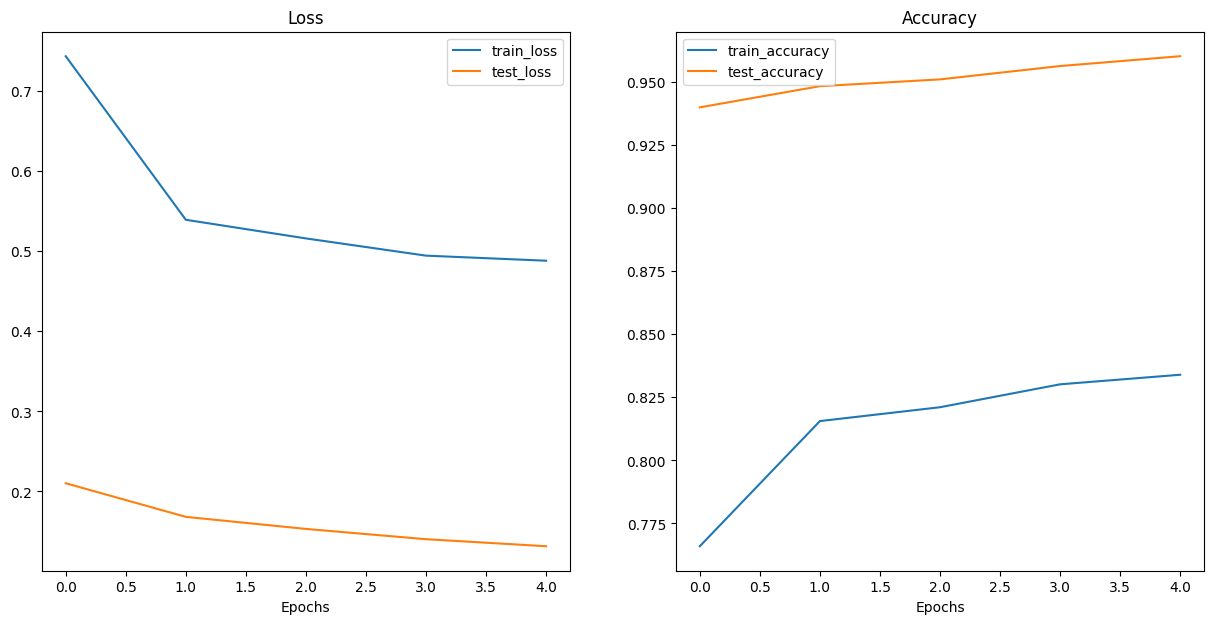

In [ ]:
from helper_functions import plot_loss_curves

# Check out the loss curves for FoodVision Big
plot_loss_curves(vit_CIFAR_results)

In [ ]:
from going_modular.going_modular import utils

# Create a model path
vit_CIFAR_model_path = "09_pretrained_vit_feature_extractor_CIFAR_20_percent.pth"

# Save model
utils.save_model(model=vit_CIFAR,
                 target_dir="models",
                 model_name=vit_CIFAR_model_path)

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_CIFAR_20_percent.pth


In [ ]:
loaded_vit_CIFAR, vit_CIFAR__transforms = create_vit_model(num_classes=10)

# Load the saved model's state_dict()
loaded_vit_CIFAR.load_state_dict(torch.load("models/09_pretrained_vit_feature_extractor_CIFAR_20_percent.pth"))

<All keys matched successfully>

In [ ]:
from pathlib import Path
# Get the model size in bytes then convert to megabytes
pretrained_vit_CIFAR_model_size = Path("models", vit_CIFAR_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained Vit feature extractor Food101 model size: {pretrained_vit_CIFAR_model_size} MB")

Pretrained Vit feature extractor Food101 model size: 327 MB


## Upload to HuggingFace Space

In [ ]:
from pathlib import Path

CIFAR_demo_path = Path("demos/CIFAR/")
CIFAR_demo_path.mkdir(parents=True, exist_ok=True)
(CIFAR_demo_path/ "examples").mkdir(parents=True, exist_ok=True)

In [ ]:
CIFAR_class_names_path = CIFAR_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(CIFAR_class_names_path, "w") as f:
    print(f"[INFO] Saving CIFAR class names to {CIFAR_class_names_path}")
    f.write("\n".join(CIFAR_class_names)) # leave a new line between each class

[INFO] Saving CIFAR class names to demos/CIFAR/class_names.txt


In [ ]:
with open(CIFAR_class_names_path, "r") as f:
    CIFAR_class_names_loaded = [CIFAR.strip() for CIFAR in  f.readlines()]

# View the first 5 class names loaded back in
CIFAR_class_names_loaded[:5]

['airplane', 'automobile', 'bird', 'cat', 'deer']

In [ ]:
%%writefile demos/CIFAR/model.py
import torch
import torchvision
from torch import nn

def create_vit_model(num_classes:int=10,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

Writing demos/CIFAR/model.py


In [ ]:
%%writefile demos/CIFAR/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_vit_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [CIFAR_name.strip() for CIFAR_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
vit_CIFAR, vit_CIFAR__transforms = create_vit_model(num_classes=10,
                                       seed=42)

# Load saved weights
loaded_vit_CIFAR.load_state_dict(
    torch.load(
        f="models/09_pretrained_vit_feature_extractor_CIFAR_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = vit_CIFAR__transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    vit.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(vit(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "CIFAR 20%"
description = "A ViT feature extractor for image classification trained on 20% of the CIFAR10 dataset."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/CIFAR/app.py


In [ ]:
%%writefile demos/CIFAR/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/CIFAR/requirements.txt


In [ ]:
# Zip foodvision_big folder but exclude certain files
!cd demos/CIFAR && zip -r ../CIFAR.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 10%)
  adding: examples/ (stored 0%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 4%)
Not running in Google Colab, can't use google.colab.files.download()


### Deploying our app to HuggingFace Spaces

B, E, A, Utiful!

Time to bring our biggest model of the whole course to life!

Let's deploy our FoodVision Big Gradio demo to Hugging Face Spaces so we can test it interactively and let others experience the magic of our machine learning efforts!

> **Note:** There are [several ways to upload files to Hugging Face Spaces](https://huggingface.co/docs/hub/repositories-getting-started#getting-started-with-repositories). The following steps treat Hugging Face as a git repository to track files. However, you can also upload directly to Hugging Face Spaces via the [web interface](https://huggingface.co/docs/hub/repositories-getting-started#adding-files-to-a-repository-web-ui) or by the [`huggingface_hub` library](https://huggingface.co/docs/huggingface_hub/index).

The good news is, we've already done the steps to do so with FoodVision Mini, so now all we have to do is customize them to suit FoodVision Big:

1. [Sign up](https://huggingface.co/join) for a Hugging Face account.
2. Start a new Hugging Face Space by going to your profile and then [clicking "New Space"](https://huggingface.co/new-space).
    * **Note:** A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.
3. Give the Space a name, for example, mine is called `mrdbourke/foodvision_big`, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_big
4. Select a license (I used [MIT](https://opensource.org/licenses/MIT)).
5. Select Gradio as the Space SDK (software development kit).
   * **Note:** You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.
6. Choose whether your Space is it's public or private (I selected public since I'd like my Space to be available to others).
7. Click "Create Space".
8. Clone the repo locally by running: `git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME]` in terminal or command prompt.
    * **Note:** You can also add files via uploading them under the "Files and versions" tab.
9. Copy/move the contents of the downloaded `foodvision_big` folder to the cloned repo folder.
10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to [install Git LFS](https://git-lfs.github.com/) (which stands for "git large file storage").
11. After you've installed Git LFS, you can activate it by running `git lfs install`.
12. In the `foodvision_big` directory, track the files over 10MB with Git LFS with `git lfs track "*.file_extension"`.
    * Track EffNetB2 PyTorch model file with `git lfs track "09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth"`.
    * **Note:** If you get any errors uploading images, you may have to track them with `git lfs` too, for example `git lfs track "examples/04-pizza-dad.jpg"`
13. Track `.gitattributes` (automatically created when cloning from HuggingFace, this file will help ensure our larger files are tracked with Git LFS). You can see an example `.gitattributes` file on the [FoodVision Big Hugging Face Space](https://huggingface.co/spaces/mrdbourke/foodvision_big/blob/main/.gitattributes).
    * `git add .gitattributes`
14. Add the rest of the `foodvision_big` app files and commit them with:
    * `git add *`
    * `git commit -m "first commit"`
15. Push (upload) the files to Hugging Face:
    * `git push`
16. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!

If everything worked correctly, our FoodVision Big Gradio demo should be ready to classify!

You can see my version here: https://huggingface.co/spaces/mrdbourke/foodvision_big/

Or we can even embed our FoodVision Big Gradio demo right within our notebook as an [iframe](https://gradio.app/sharing_your_app/#embedding-with-iframes) with [`IPython.display.IFrame`](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.IFrame) and a link to our space in the format `https://hf.space/embed/[YOUR_USERNAME]/[YOUR_SPACE_NAME]/+`.

**I made an effort locally on VSCode, didn't really work in the end with the final push, stuck with the usual Git weird error messages. Try again another time.**

## **BONUS RESOURCES**

https://www.learnpytorch.io/pytorch_extra_resources/

**APIs**
- https://azure.microsoft.com/en-au/products/machine-learning/
- https://fastapi.tiangolo.com/
- https://pytorch.org/serve/

Gradio:
- https://www.gradio.app/docs
- https://huggingface.co/learn/nlp-course/chapter9/1

"If you'd like to speed up your model's runtime on CPU, you should be aware of TorchScript, ONNX (Open Neural Network Exchange) and OpenVINO. Going from pure PyTorch to ONNX/OpenVINO models I've seen a ~2x+ increase in performance."

- https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html
- https://pytorch.org/docs/stable/onnx.html
- https://docs.openvino.ai/2022.3/notebooks/102-pytorch-onnx-to-openvino-with-output.html

AI/ML Product Design:
- https://pair.withgoogle.com/guidebook
- https://pair.withgoogle.com/guidebook/patterns#set-the-right-expectations

Moving ML Inference from the Cloud to the Edge: https://bergum.medium.com/moving-ml-inference-from-the-cloud-to-the-edge-d6f98dbdb2e3

Raspberry Pi: https://pytorch.org/tutorials/intermediate/realtime_rpi.html

Git Crash Course: https://www.youtube.com/watch?v=RGOj5yH7evk

Made With ML: https://madewithml.com/
